In [1]:
import time

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision import datasets

import medmnist
from medmnist import INFO, Evaluator

from matplotlib import pyplot as plt

from gudhi import CubicalComplex
from gudhi.sklearn.cubical_persistence import CubicalPersistence

from medmnist import PneumoniaMNIST

In [3]:
# from torchvision import transforms
from torch_cube_perslap_v2 import *

In [4]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [5]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [6]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /Users/ruidong/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/ruidong/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/ruidong/.medmnist/pneumoniamnist.npz


In [7]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /Users/ruidong/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST of size 28 (pneumoniamnist)
    Number of datapoints: 624
    Root location: /Users/ruidong/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': '

In [8]:
# visualization

train_dataset.montage(length=1)

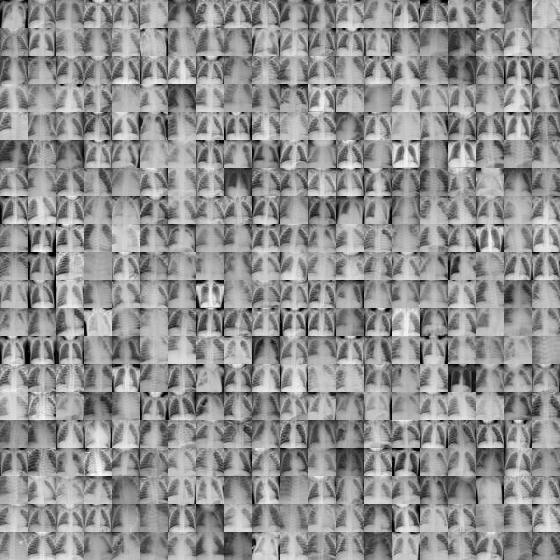

In [9]:
# montage

train_dataset.montage(length=20)

In [10]:
train_dataset_flip = [(1 - img, _) for img, _ in train_dataset]
# mnist2_val_flip = [(1 - img, _) for img, _ in mnist2_val]

In [11]:
test_dataset_flip = [(1-img, _) for img, _ in test_dataset]

# Persistent Laplacian

# img, label=1

In [12]:
img, lb = train_dataset_flip[0]

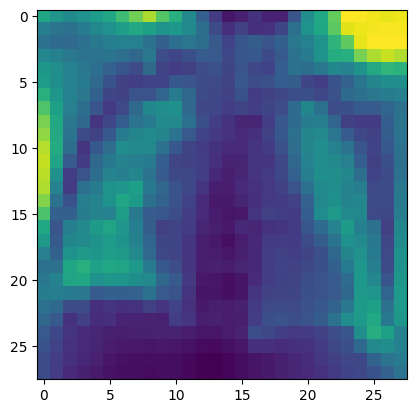

In [13]:
plt.imshow(img.permute(1, 2, 0))

In [17]:
cell_dim=1
start=0.2
end=1.0
steps=15
channel=0

# eig_idx = 2

In [18]:
st = time.time()

tst_lap = perslap_eigs_pairs_up(img, cell_dim, start=start, end=end, steps=steps, channel=channel)

et = time.time()
print(et - st)

1.6129570007324219


In [19]:
tst_lap

[tensor(0.4487),
 tensor(0.2723),
 tensor(0.1284),
 tensor(0.0842),
 tensor(0.0711),
 tensor(0.0636),
 tensor(0.0380),
 tensor(0.0301),
 tensor(0.0251),
 tensor(0.0246),
 tensor(0.0245),
 tensor(0.0242),
 tensor(0.0241),
 tensor(0.0237)]

# Eigenvalues of Persistent up 1-Laplacian

In [172]:
img2, lb2 = train_dataset_flip[5]

In [173]:
lb2

array([0])

In [174]:
[lb for img, lb in train_dataset][0:10]

[array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([0]),
 array([1]),
 array([1])]

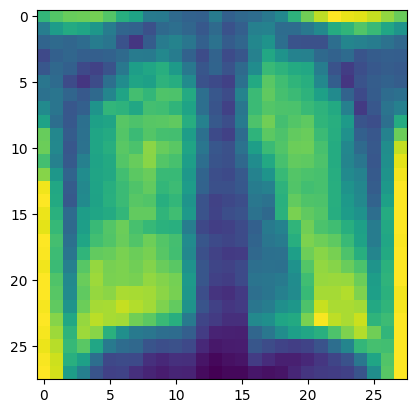

In [175]:
plt.imshow(img2.permute(1, 2, 0))

In [176]:
st = time.time()

tst_lap_2 = perslap_eigs_pairs(img2, cell_dim, start=start, end=end, steps=steps, channel=channel, eig_idx=eig_idx)

et = time.time()
print(et - st)

0.9045319557189941


In [177]:
img3, lb3 = train_dataset_flip[1]

In [178]:
lb3

array([1])

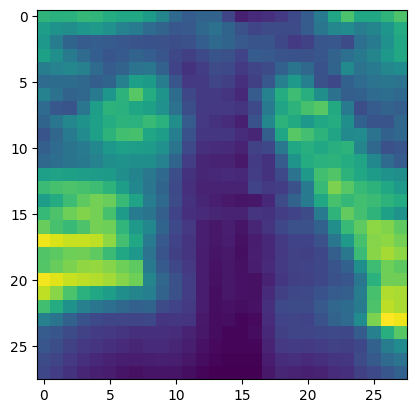

In [179]:
plt.imshow(img3.permute(1, 2, 0))

In [180]:
st = time.time()

tst_lap3 = perslap_eigs_pairs(img3, cell_dim, start=start, end=end, steps=steps, channel=channel, eig_idx=eig_idx)

et = time.time()
print(et - st)

1.994568109512329


In [85]:
st = time.time()

lap_egns_1 = [perslap_eigs_pairs_up(img, cell_dim, start=start, end=end, steps=steps, channel=channel) for img, _ in train_dataset_flip[0:500]]
# [perslap_eigs(img[0], cell_dim=cell_dim, start=start, end=end, steps=steps) for img in mnist2_flip[0:1000]]

et = time.time()
print(et - st)

766.5013508796692


In [86]:
torch_lap_egns_1 = torch.stack([torch.stack(eig_vals) for eig_vals in lap_egns_1])

In [87]:
torch.save(torch_lap_egns_1, "eigenvalues/lap_egns_1_up_pneum.pt")

In [88]:
st = time.time()

lap_egns_2 = [perslap_eigs_pairs_up(img, cell_dim, start=start, end=end, steps=steps, channel=channel) for img, _ in train_dataset_flip[500:1100]]
# [perslap_eigs(img[0], cell_dim=cell_dim, start=start, end=end, steps=steps) for img in mnist2_flip[0:1000]]

et = time.time()
print(et - st)

1698.133610010147


In [89]:
torch_lap_egns_2 = torch.stack([torch.stack(eig_vals) for eig_vals in lap_egns_2])

In [90]:
torch.save(torch_lap_egns_2, "eigenvalues/lap_egns_2_up_pneum.pt")

In [91]:
st = time.time()

lap_egns_3 = [perslap_eigs_pairs_up(img, cell_dim, start=start, end=end, steps=steps, channel=channel) for img, _ in train_dataset_flip[1100:3000]]
# [perslap_eigs(img[0], cell_dim=cell_dim, start=start, end=end, steps=steps) for img in mnist2_flip[0:1000]]

et = time.time()
print(et - st)

3226.6729209423065


In [92]:
torch_lap_egns_3 = torch.stack([torch.stack(eig_vals) for eig_vals in lap_egns_3])

In [93]:
torch.save(torch_lap_egns_3, "eigenvalues/lap_egns_3_up_pneum.pt")

In [94]:
st = time.time()

lap_egns_4 = [perslap_eigs_pairs_up(img, cell_dim, start=start, end=end, steps=steps, channel=channel) for img, _ in train_dataset_flip[3000:3900]]
# [perslap_eigs(img[0], cell_dim=cell_dim, start=start, end=end, steps=steps) for img in mnist2_flip[0:1000]]

et = time.time()
print(et - st)

1561.1039400100708


In [95]:
torch_lap_egns_4 = torch.stack([torch.stack(eig_vals) for eig_vals in lap_egns_4])

In [96]:
torch.save(torch_lap_egns_4, "eigenvalues/lap_egns_4_up_pneum.pt")

In [97]:
st = time.time()

lap_egns_5 = [perslap_eigs_pairs_up(img, cell_dim, start=start, end=end, steps=steps, channel=channel) for img, _ in train_dataset_flip[3900:]]
# [perslap_eigs(img[0], cell_dim=cell_dim, start=start, end=end, steps=steps) for img in mnist2_flip[0:1000]]

et = time.time()
print(et - st)

1397.56853723526


In [98]:
torch_lap_egns_5 = torch.stack([torch.stack(eig_vals) for eig_vals in lap_egns_5])

In [99]:
torch.save(torch_lap_egns_5, "eigenvalues/lap_egns_5_up_pneum.pt")

In [189]:
len(train_dataset_flip)

4708

In [191]:
lap_egns_1[0]

[tensor([0.0108, 0.0256, 0.0557]),
 tensor([0.0106, 0.0202, 0.0287]),
 tensor([0.0040, 0.0057, 0.0134]),
 tensor([0.0040, 0.0055, 0.0133]),
 tensor([0.0043, 0.0059, 0.0140]),
 tensor([0.0040, 0.0054, 0.0144]),
 tensor([-8.7934e-07,  9.1451e-07,  8.5716e-03]),
 tensor([-3.6546e-06,  1.0057e-06,  1.0813e-02]),
 tensor([1.0462e-06, 1.1349e-02, 1.2656e-02]),
 tensor([0.0117, 0.0127, 0.0248]),
 tensor([0.0117, 0.0126, 0.0246]),
 tensor([0.0116, 0.0125, 0.0244]),
 tensor([0.0116, 0.0124, 0.0242]),
 tensor([0.0117, 0.0124, 0.0237])]

# Test dataset

In [100]:
len(test_dataset_flip)

624

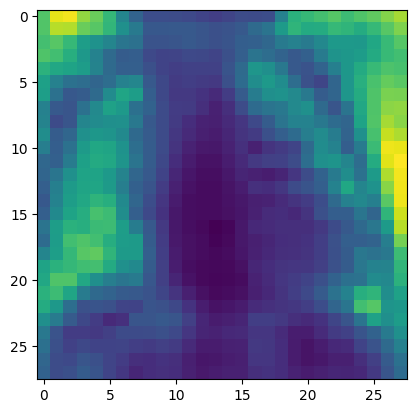

In [224]:
plt.imshow(test_dataset_flip[0][0].permute(1, 2, 0))

In [101]:
st = time.time()

lap_egns_test = [perslap_eigs_pairs_up(img, cell_dim, start=start, end=end, steps=steps, channel=channel) for img, _ in test_dataset_flip]
# [perslap_eigs(img[0], cell_dim=cell_dim, start=start, end=end, steps=steps) for img in mnist2_flip[0:1000]]

et = time.time()
print(et - st)

940.4082329273224


In [102]:
torch_lap_egns_test = torch.stack([torch.stack(eig_vals) for eig_vals in lap_egns_test])

In [103]:
torch.save(torch_lap_egns_test, "eigenvalues/lap_egns_test_up_pneum.pt")

In [240]:
train_labels = torch.stack([torch.tensor(lb) for img, lb in train_dataset])

In [241]:
torch.save(train_labels, "eigenvalues/train_labels_pneum.pt")

In [243]:
test_labels = torch.stack([torch.tensor(lb) for img, lb in test_dataset])

In [244]:
torch.save(test_labels, "eigenvalues/test_labels_pneum.pt")